# Linear vortex panel method

By Jiayu Li

Welcome to the final project! During this semester, I think I really learn a lot from this class. 

In lesson 11, we have already learned how to solve the problem with constant vortex strength. This time I will make the strength linearly varying.

# Derivation of the linearly varying vortex panel method

Linearly varying vortex strength means:   
\begin{equation}
\begin{split} \gamma(x)=\gamma_{0}+\gamma_1(x-x_1)
\end{split}
\end{equation}

$γ_0$ is a constant part, and $γ_1(x-x_1)$ is the slope. By superposition, we can divide it into two parts, the constant part and varying part, and then add them together.

From lesson 11 we have already learned that the potential at location $(x, y)$ induced by an uniform flow and a vortex sheet can be represented as: 

\begin{equation}
\begin{split}
\phi(x, y) 
&= \phi_{freestream}(x, y)+ \phi_{vortex}(x, y)
\end{split}
\end{equation}

\begin{equation}
\begin{split}
\phi(x, y) &= xU_{\infty}\cos(\alpha) + yU_{\infty}\sin(\alpha) &-
\frac{1}{2\pi} \int_{sheet} \gamma(s)\tan^{-1} (\frac{y-\eta(s)}{x-\xi(s)})ds= xU_{\infty}\cos(\alpha) + yU_{\infty}\sin(\alpha)- \sum_{j=1}^N \frac{1}{2\pi} \int_j\gamma_j(s) \tan^{-1} \left(\frac{y-\eta_j(s)}{x-\xi_j(s)}\right) {\rm d}s_j
\end{split}
\end{equation}

\begin{equation}
\left\{
\begin{array}{l}
\xi_j(s)=x_j-s\sin\beta_j \\
\eta_j(s)=y_j+s\cos\beta_j
\end{array}
,\ \ \ 
0\le s \le l_j
\right.
\end{equation}

When the vortex strength is linearly varying, we can derive:

\begin{equation}
\begin{split} \gamma_j(s)=\gamma_j+(\frac{\gamma_{j+1}-\gamma_j}{l_j})s
\end{split}
\end{equation}

$$
\begin{align*}
\phi\left(x,y\right) &= xU_{\infty}\cos(\alpha) + yU_{\infty}\sin(\alpha)- \sum_{j=1}^N \frac{\gamma_j}{2\pi} \int_j \tan^{-1} \left(\frac{y-\eta_j(s)}{x-\xi_j(s)}\right) {\rm d}s_j- \sum_{j=1}^N \frac{1}{2\pi}(\frac{\gamma_{j+1}-\gamma_j}{l_j}) \int_j s\tan^{-1} \left(\frac{y-\eta_j(s)}{x-\xi_j(s)}\right) {\rm d}s_j
\end{align*}
$$

# Part 1: Angle of attack: 0

# Discretization into panels

Let's first import our favorite libraries, and the function integrate and linalg from SciPy, as in Lesson 11.

In [1]:
# import libraries and modules needed
import os
import math
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

We start by importing the NACA0012 geometry from a data file:

In [2]:
# load geometry from data file
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

Then we plot the airfoil:

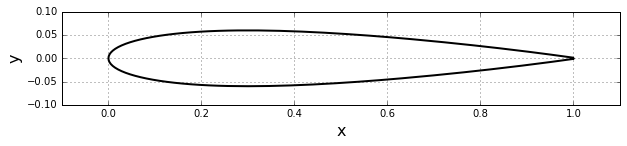

In [3]:
# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

We define a class Panel that will store all information about one panel: start and end points, center point, length, orientation, tangential velocity and pressure coefficient, as the same in lesson 11.

In [4]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya                       # panel starting-point
        self.xb, self.yb = xb, yb                       # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'                          # upper surface
        else:
            self.loc = 'lower'                          # lower surface
        
        
        self.vt = 0.0                                   # tangential velocity
        self.cp = 0.0                                   # pressure coefficient

Like before, we call the function define_panels to discretize the airfoil geometry in N panels. We are going to generate the y_ends using the equation for a symmetrical 4-digit NACA airfoil with the correction for zero-thickness trailing edge.

In [5]:
def define_panels(N):
    """Discretizes the geometry into panels using 'cosine' method.
    
    Arguments
    ---------
    N: number of panels 
    
    Returns
    -------
    panels: Numpy array of panels
    """
    
    R = (x.max()-x.min())/2.                            
    x_center = (x.max()+x.min())/2.                     
    
    theta = numpy.linspace(0, 2*numpy.pi, N+1)          
    x_circle = x_center +  R*numpy.cos(theta)           
    
    x_ends = numpy.copy(x_circle)                       
    y_ends = numpy.empty_like(x_ends)                   
    y_t = numpy.empty_like(x_ends)                      
    
    x_ends = numpy.append(x_ends, x_ends[0])            
    
    t=0.12                                              
                                                        
    c=1.                                                
    
    y_t = 5.*t*c*(0.2969*numpy.sqrt(x_ends/c) + (-0.1260)*(x_ends/c)+\
                    (-0.3516)*(x_ends/c)**2 + (0.2843)*(x_ends/c)**3 +\
                    (-0.1036)*(x_ends/c)**4)
    
    # computes the y_end
    
    y_ends[0:N/2] = y_t[0:N/2]
    y_ends[N/2:N+1] = -y_t[N/2:N+1]
    
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Now we can use the new function to define the geometry for the airfoil panels, and then plot the panel nodes on the geometry.

In [6]:
# discretize geoemetry into panels
N = 100                            # number of panels
panels = define_panels(N)          # discretizes of the geometry into panels

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


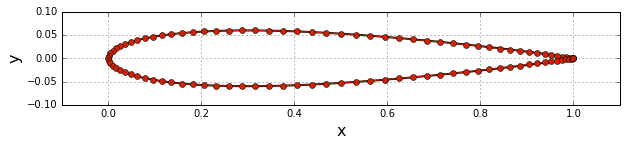

In [7]:
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

# Freestream Condition

The airfoil is immersed in a freestream $(U_\infty$,$\alpha)$ where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack, respectively. 

In [8]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf, alpha):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            
        alpha: float, optional
            Angle of attack in degrees;
            
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [9]:
# define freestream conditions
u_inf = 1.0                                # freestream speed
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

# Flow tangency boundary condition

From lesson 11 we have already learned:

\begin{equation}
\left\{
\begin{array}{l}
U_n(x, y)=\frac{\partial \phi}{\partial x}(x, y) n_x(x, y)+\frac{\partial \phi}{\partial y}(x, y) n_y(x, y) \\
U_t(x, y)=\frac{\partial \phi}{\partial x}(x, y) t_x(x, y)+\frac{\partial \phi}{\partial y}(x, y) t_y(x, y)
\end{array}
\right.
\end{equation}

\begin{equation}
\left\{
\begin{array}{l}
n_x= cos(\beta_i), n_y= sin(\beta_i) \\
t_x= -sin(\beta_i), t_y= cos(\beta_i)
\end{array}
\right.
\end{equation}

So we can derive:

\begin{equation}
\left\{
\begin{array}{l}
U_n(x,y)=U_{\infty}\cos(\alpha-\beta_i)+\frac{1}{2\pi}\sum_{j=1}^N \gamma_j(\int_{j} f_j(s)ds\cos(\beta_i)-\int_{j} g_j(s)ds\sin(\beta_i))-\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_j}{l_j}(\int_{j} sf_j(s)ds\cos(\beta_i)-\int_{j} sg_j(s)ds\sin(\beta_i))+\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_{j+1}}{l_j}(\int_{j} sf_j(s)ds\cos(\beta_i)-\int_{j} sg_j(s)ds\sin(\beta_i)) \\
U_t(x,y)=U_{\infty}\sin(\alpha-\beta_i)+\frac{1}{2\pi}\sum_{j=1}^N \gamma_j(\int_{j} f_j(s)ds(-sin(\beta_i))-\int_{j} g_j(s)ds\cos(\beta_i))-\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_j}{l_j}(\int_{j} sf_j(s)ds(-sin(\beta_i))-\int_{j} sg_j(s)ds\cos(\beta_i))+\frac{1}{2\pi}\sum_{j=1}^N \frac{\gamma_{j+1}}{l_j}(\int_{j} sf_j(s)ds(-sin(\beta_i))-\int_{j} sg_j(s)ds\cos(\beta_i))
\end{array}
\right.
\end{equation}

\begin{equation}
\left\{
\begin{array}{l}
f_j(s)=\frac{(y-\eta_j(s))}{(x-\xi_j(s))^2+(y-\eta_j(s))^2} \\
g_j(s)=\frac{(x-\xi_j(s))}{(x-\xi_j(s))^2+(y-\eta_j(s))^2}
\end{array}
\right.
\end{equation}

In [10]:
def integral_1(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
def integral_2(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return (s* ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [12]:
def vortex_normal_1(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A1: 2D Numpy array of floats
        The first part vortex contribution matrix.
    A2: 2D Numpy array of floats
        The second part vortex contribution matrix.
    A3: 2D Numpy array of floats
        The third part vortex contribution matrix.
    """
    N = len(panels)
    A1 = numpy.empty((N, N), dtype=float)  
    numpy.fill_diagonal(A1, 0.)  
    

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):                
            if i != j:
                A1[i,j] = 0.5/numpy.pi*(integral_1(p_i.xc, p_i.yc, p_j, -numpy.sin(p_i.beta),numpy.cos(p_i.beta)))
                         
    return A1

In [13]:
def vortex_normal_2(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A1: 2D Numpy array of floats
        The first part vortex contribution matrix.
    A2: 2D Numpy array of floats
        The second part vortex contribution matrix.
    A3: 2D Numpy array of floats
        The third part vortex contribution matrix.
    """
    N = len(panels)
    A2 = numpy.empty((N, N), dtype=float)          
    numpy.fill_diagonal(A2, -0.5/numpy.pi) 
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):    
            if i != j:
                A2[i,j] = (0.5/numpy.pi)*(1./p_j.length)*(integral_2(p_i.xc, p_i.yc, p_j, -numpy.sin(p_i.beta),numpy.cos(p_i.beta)))
                         
    return A2

In [14]:
def vortex_normal_3(panels, A2):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A1: 2D Numpy array of floats
        The first part vortex contribution matrix.
    A2: 2D Numpy array of floats
        The second part vortex contribution matrix.
    A3: 2D Numpy array of floats
        The third part vortex contribution matrix.
    """
    N = len(panels)
    A3 = A2
                         
    return A3

In [15]:
#Let's call this functions to create A1,A2,A3.
A1 = vortex_normal_1(panels)
A2 = vortex_normal_2(panels)
A3 = vortex_normal_3(panels,A2)

In [16]:
def A_normal(panels,A1,A2,A3):
    """Builds the normal matrix
    
    Arguments
    ---------
    panels: panels of the geometry
    A1: term related to the first integral in U_n
    A2: term related to the second integral in U_n
    A3: term related to the third integral in U_n
    
    Returns
    -------
    A_n: Nx(N+1) matrix, where N is number of panels. 
    
    """
    N = len(panels)
    A_n = numpy.zeros((N, N+1), dtype=float) 
    
    for i in range(N):
        
        A_n[i,0] = A1[i,0] - A2[i,0]
        A_n[i,-1] = A3[i,-1]
        
        for j in range(N-1):
            
            A_n[i,j+1] = A1[i,j+1] - A2[i,j+1] + A3[i,j]
    
    return A_n

# Kutta condition

In this case, the Kutta condition must meet: $\gamma_0+\gamma_N=0$

In [17]:
#Kutta condition

def kutta_array(N):
    """Builds the kutta array.
    
    Arguments
    ---------
    N: number of panels
    
    Returns
    -------
    k_a -- 1D array ((N+1)x1, N is the number of panels). kutta array
    """
    k_a = numpy.zeros(N+1,dtype=float)

    k_a[0] = 1.
    k_a[-1] = 1.
    
    return k_a

# Build the matrix

Here, we build and solve the linear system of equations of the form

$$[A][\gamma] = [b]$$

In [18]:
def build_matrix(A_n, k_a, N):
    """Builds the A matrix to solve the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: Nx(N+1) matrix (N is the number of panels).
    k_a -- 1D array ((N+1)x1, N is the number of panels).
    Returns
    -------
    A_solve: (N+1)x(N+1) matrix (N is the number of panels).
    """

    #Matrix A_solve (N+1)x(N+1)

    A_solve = numpy.empty((N+1, N+1), dtype=float)
    
    A_solve[0:N,:] = A_n[:,:]
    A_solve[-1,:] = k_a[:]

    return A_solve


In [19]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    freestream: farfield conditions.
    
    Returns
    -------
    b: 1D array ((N+1)x1, N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+1,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-1] = 0.
    
    return b

In [20]:
N=len(panels)
A_n =A_normal(panels,A1,A2,A3)
k_a = kutta_array(N)

# compute the matrix
A = build_matrix(A_n, k_a, N)

# compute the freestream RHS
b = build_rhs(panels, freestream)

In [21]:
# solves the linear system
gammas = linalg.solve(A, b)

# Surface pressure coefficient

From Bernoulli's equation, the pressure coefficient is:

\begin{equation}C_{p} = 1-\left(\frac{v_{t}}{U_\infty}\right)^2
\end{equation}

In [22]:
def vortex_tangential_1(panels):
    
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    B1: 2D Numpy array of floats
        The first part contribution matrix
    B2: 2D Numpy array of floats
        The second part contribution matrix
    B3: 2D Numpy array of floats
        The third part contribution matrix
    """

    N = len(panels)
    B1 = numpy.empty((N, N), dtype=float)          
    numpy.fill_diagonal(B1, -0.5)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):                
            if i != j:
                B1[i,j] = 0.5/numpy.pi*(integral_1(p_i.xc, p_i.yc, p_j,-numpy.cos(p_i.beta), -numpy.sin(p_i.beta)))
                         
    return B1

In [23]:
def vortex_tangential_2(panels):
    
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    B1: 2D Numpy array of floats
        The first part contribution matrix
    B2: 2D Numpy array of floats
        The second part contribution matrix
    B3: 2D Numpy array of floats
        The third part contribution matrix
    """
    N = len(panels)
    B2 = numpy.empty((N, N), dtype=float)          
    numpy.fill_diagonal(B2, -0.25)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):                
            if i != j:
                B2[i,j] = 0.5/numpy.pi*(1./p_j.length)*(integral_2(p_i.xc, p_i.yc, p_j,-numpy.cos(p_i.beta), -numpy.sin(p_i.beta)))
                        
    return B2

In [24]:
def vortex_tangential_3(panels, B2):
   
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    B1: 2D Numpy array of floats
        The first part contribution matrix
    B2: 2D Numpy array of floats
        The second part contribution matrix
    B3: 2D Numpy array of floats
        The third part contribution matrix
    """
    N = len(panels)
    B3 = B2
                         
    return B3

In [25]:
#Let's call this functions to create B1,B2,B3.
B1 = vortex_tangential_1(panels)
B2 = vortex_tangential_2(panels)
B3 = vortex_tangential_3(panels,B2)

In [26]:
def A_tangential(panels,B1,B2,B3):
    """Builds the tangential matrix
    
    Arguments
    ---------
    panels: panels of the geometry
    B1: term related to the first integral in U_t
    B2: term related to the second integral in U_t
    B3: term related to the third integral in U_t
    
    Returns
    -------
    A_t: Nx(N+1) matrix, where N is number of panels. 
    """
    N = len(panels)
    A_t = numpy.zeros((N, N+1), dtype=float) 
    
    for i in range(N):
        
        A_t[i,0] = B1[i,0] - B2[i,0]
        A_t[i,-1] = B3[i,-1]
        
        for j in range(N-1):
            
            A_t[i,j+1] = B1[i,j+1] - B2[i,j+1] + B3[i,j]
    
    return A_t

In [27]:
A_t = A_tangential(panels,B1,B2,B3)
b_t = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])

v_t = numpy.dot(A_t, gammas) + b_t
for i, panel in enumerate(panels):
        panel.vt = v_t[i]

In [28]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [29]:
# surface pressure coefficient
get_pressure_coefficient(panels, freestream)

# Theoretical solution

In [30]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [31]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


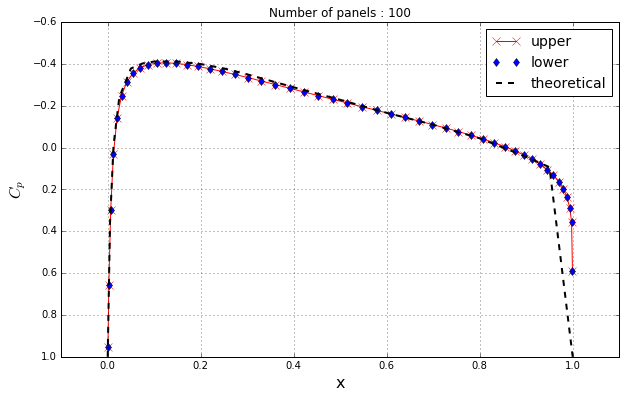

In [32]:
# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : %d' % N);

Well, the only place where the panel method doesn't quite match with the theoretical data is at the trailing edge. But note that the flow-tangency boundary condition in the panel method is applied at the control point of the panel (not at the endpoints), so this discrepancy is not surprising.

# Part 2: Angle of attack: 10

In [33]:
u_inf = 1.0                                 # freestream speed
alpha = 10.0                                # angle of attack (in degrees)
freestream_1 = Freestream(u_inf, alpha)      # instantiation of the object freestream

In [34]:
b_1 = build_rhs(panels, freestream_1)
gammas_1 = linalg.solve(A, b_1)
b_t_1 = freestream.u_inf * numpy.sin([freestream_1.alpha - panel.beta for panel in panels])
v_t_1 = numpy.dot(A_t, gammas_1) + b_t_1
for i, panel in enumerate(panels):
        panel.vt = v_t_1[i]
get_pressure_coefficient(panels, freestream_1)

We next load the experimental data for the coefficient of pressure of the upper face when the angle of attack is 10 degrees.

In [35]:
x_exp , Cp_exp = numpy.loadtxt('CP_Gregory_expdata.dat', dtype=float, delimiter=' ', unpack=True)

Time to plot the result!

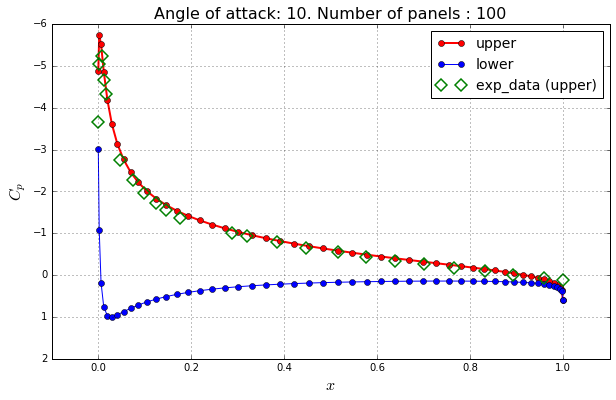

In [36]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.plot(x_exp,Cp_exp,color='g', linewidth=0, marker='D', markersize=8, markeredgecolor='g',
markerfacecolor='None', markeredgewidth=1.5)
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-6.0, 2.0)
pyplot.legend(['upper', 'lower', 'exp_data (upper)'], loc='best', prop={'size':14})
pyplot.gca().invert_yaxis()
pyplot.title('Angle of attack: 10. Number of panels : %d' % N, fontsize=16);

Well, the pressure coefficient match well with the experimental data of the upper surface.

# Part 3: Percentage error

When the angle of attack is 10 degrees, the experimental data of lift is 1.2219. By using this data and the percentage error, we can see how our model behaves.

In [37]:
def get_lift(freestream, Np):
    """
    Get the lift coefficient for a number of panels Np
    """
    #define panels
    panels = define_panels(Np)
    
    #coefficients to build A
    A1 = vortex_normal_1(panels)
    A2 = vortex_normal_2(panels)
    A3 = vortex_normal_3(panels,A2)
    
    #To build A
    A_n =A_normal(panels,A1,A2,A3)
    k_a = kutta_array(Np)

    #Putting all together to get A
    A = build_matrix(A_n, k_a, Np)

    #RHS
    b = build_rhs(panels, freestream)

    # solves the linear system
    gammas = linalg.solve(A, b)
    
    #Coefficients to get A_tangential.
    B1 = vortex_tangential_1(panels)
    B2 = vortex_tangential_2(panels)
    B3 = vortex_tangential_3(panels,B2)
    
    #A_tangential
    A_t = A_tangential(panels,B1,B2,B3)
    
    #The vector associated with the free-stream for U_t
    b_t = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])

    #Get tangential velocity
    v_t = numpy.dot(A_t, gammas) + b_t
    
    for i, panel in enumerate(panels):
        panel.vt = v_t[i]
    
    #Get Cp
    get_pressure_coefficient(panels, freestream)
    
    L = 0.
    for panel in panels:
        L -= panel.cp*panel.length*numpy.sin(panel.beta)
    
    return L

In [38]:
L_np=[]
Np_list=[20,40,60,80,100,120,140,160,180,200]
for i in Np_list:
    L_np.append(get_lift(freestream_1, i))

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [39]:
L_exp = 1.2219
#percentage error
per_err = []
for i in L_np:
    per_err.append(100*numpy.abs(L_exp - i)/L_exp)

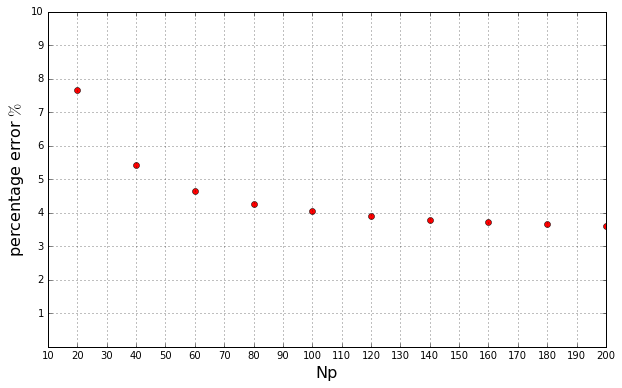

In [40]:
#Plotting
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('Np', fontsize=16)
pyplot.ylabel('percentage error $\%$', fontsize=16)
pyplot.xlim(10, 200)
pyplot.ylim(0, 10)
pyplot.xticks(numpy.linspace(10, 200, 20)) 
pyplot.yticks(numpy.linspace(1, 10, 10))
pyplot.plot(Np_list, per_err,color='r', linewidth=0, marker='o', markersize=6);

Therefore, when the Np is increasing, the percentage error will be decreasing. So, this is a good method to solve a problem when Np is big enough.

# Conclusions

From part 1 we can see that the coefficient of pressure matches well with the theoretical one, excluding the trailing edge. But flow-tangency boundary condition is not applied at endpoints, so this discrepancy is not surprising.  

In addition, the purpouse of using vortices as our singularities is to get some lift and see how our model behaves. From part 2, when the angle of attack is 10 degrees, our results of upper surface seem to match the experimental data. 

In part 3, we calculate the value of the lift coefficients for different number of panels and compare it with the value of the experimental data. Therefore, we can see how the error behaves for different number of panels. When the number of panels increases, the percentage of error decreases.

# References

1. Katz, J. & Plotkin, A. Low speed aerodynamics. 1947.
2. https://turbmodels.larc.nasa.gov/naca0012_val.html
3. https://en.wikipedia.org/wiki/NACA_airfoil